# Wind Speed Analysis at Dublin Airport: insights and trends
***


![redanemometer](redanemometer.jpg)

## Context and Purpose
***

This project aims to analyze wind direction trends at Dublin Airport using weather data collected by [Met Éireann](https://www.met.ie/climate/available-data/historical-data) from the year 2000 to 2024. Wind direction significantly influences airport operations, including flight scheduling, runway usage, and safety measures. By examining these trends over time, the project provides insights that can help optimize airport planning and improve decision-making.

Aims:
- Analyze wind direction trends by year and month to identify patterns.
- Evaluate the impact of wind patterns on airport operations.
- Provide actionable insights to support operational strategies at Dublin Airport.
- Generate data that could aid in future wind farm installations by providing an understanding of regional wind behavior.

By understanding these trends, airport managers can anticipate weather-related disruptions, improve safety protocols, and ensure smoother operations throughout the year. Moreover, the insights gained could be valuable for assessing the viability of wind energy projects, as wind behavior patterns are crucial for optimal wind farm site selection and energy generation forecast.

## Getting ready
***

### Importing Libraries


In [428]:
# Data frames
import pandas as pd

# Interact with SQLite database
import sqlite3

# Importing matplotlib for plotting
import matplotlib.pyplot as plt

# Importing colormap module in Matplotlib
import matplotlib.cm as cm

# Import numpy
import numpy as np

# Importing scikit-learn (sklearn) for machine learning tasks
import sklearn 

# Importing specific functions from scikit-learn (sklearn).
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression



### Set up and installing

Ensure all the necessary tools are installed in Python environment:

1. Run in the terminal the following commands to install Jupyter notebook and pandas:


    `pip install notebook`

    `pip install pandas`

    `pip install scikit-learn`


2. Check Jupyter extension is installed

3. Start the Kernel if It is not running to make sure the execution of all cells and output results.

## Loading data
***

The dataset loading was collected from [Met Éireann](https://www.met.ie/climate/available-data/historical-data) and has been cleaned and filtered to include data from January 2000 to December 2024. Additionally, some variables have been reduced for the purposes of this study.

### Loading CSV file data

In [429]:
# Loading data into notebook from csv file
data = pd.read_csv("clean_data_DublinAirport_weather.csv")

C:\Users\noemi\AppData\Local\Temp\ipykernel_16676\2029276336.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("clean_data_DublinAirport_weather.csv")


### Creating SQLite connection and load data

Create a SQLite database (if it does not already exist) by importing data from a .csv file into a table within the .db file.

In [430]:

# Create and connect to SQLite database
conn = sqlite3.connect('DublinAirport_weather.db') # It creates a .db file

cursor = conn.cursor()

# Write the DataFrame to SQLite as a table
data.to_sql('DublinAirport_weather_data', conn, if_exists='replace', index=False)

# Check if the data was loaded correctly
cursor.execute("SELECT * FROM DublinAirport_weather_data LIMIT 5;")
print(cursor.fetchall())
cursor.execute("SELECT COUNT(*) FROM DublinAirport_weather_data;")
print(cursor.fetchone())

# Close connection
conn.close()



[('01/01/2000 01:00', 3.3, 7, '250'), ('01/01/2000 02:00', 3.4, 8, '250'), ('01/01/2000 03:00', 2.2, 6, '240'), ('01/01/2000 04:00', 2.2, 6, '230'), ('01/01/2000 05:00', 1.9, 7, '250')]
(218424,)


## Examine dataset
***

The dataset used from Met Eireann at Dublin Airport has been cleaned and organized focus on four variables between the years 2000 and 2025:

- date: date
- airtemp: air tempeture in °C
- wdsp: Wind speed
- wddir: Wind direction

In [431]:
# Information about columns names and data types of variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218424 entries, 0 to 218423
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   date     218424 non-null  object 
 1   airtemp  218424 non-null  float64
 2   wdsp     218424 non-null  int64  
 3   wddir    218424 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.7+ MB


In [432]:
# Check for missing values
data.isnull().sum()


date       0
airtemp    0
wdsp       0
wddir      0
dtype: int64

In [433]:
# show the data
data.head()

,date,airtemp,wdsp,wddir
0,01/01/2000 01:00,3.3,7,250
1,01/01/2000 02:00,3.4,8,250
2,01/01/2000 03:00,2.2,6,240
3,01/01/2000 04:00,2.2,6,230
4,01/01/2000 05:00,1.9,7,250


In [434]:
# Statistics summary of numerical variables
data.describe()


,airtemp,wdsp
count,218424.000000,218424.000000
mean,9.857803,10.303927
std,5.025941,5.295946
min,-11.500000,0.000000
25%,6.300000,6.000000
50%,10.000000,10.000000
75%,13.500000,13.000000
max,29.100000,45.000000


In [435]:
# Check columns in Dataframe
print(data.columns)  

Index(['date', 'airtemp', 'wdsp', 'wddir'], dtype='object')


## Organizing dataset with SQLite
***

### Examine data

In [436]:

# Reopen the connection
conn = sqlite3.connect('DublinAirport_weather.db')

# Fetch first 5 rows into a DataFrame
query = "SELECT * FROM DublinAirport_weather_data LIMIT 5;"
first_five_rows = pd.read_sql(query, conn)

print(first_five_rows)

# Close the connection
conn.close()


               date  airtemp  wdsp wddir
0  01/01/2000 01:00      3.3     7   250
1  01/01/2000 02:00      3.4     8   250
2  01/01/2000 03:00      2.2     6   240
3  01/01/2000 04:00      2.2     6   230
4  01/01/2000 05:00      1.9     7   250


### Reformat date to the right format yyyy-mm-dd HH:MM

In [437]:
# Connect to SQLite database
conn = sqlite3.connect('DublinAirport_weather.db')
cursor = conn.cursor()

# Ensure date column exists and update format
try:
    # Create a backup of the original date column (optional)
    cursor.execute("ALTER TABLE DublinAirport_weather_data ADD COLUMN original_date TEXT;")
    cursor.execute("UPDATE DublinAirport_weather_data SET original_date = date;")

    # Update the date format (from dd/mm/yyyy HH:MM to yyyy-mm-dd HH:MM)
    cursor.execute("""
        UPDATE DublinAirport_weather_data
        SET date = substr(original_date, 7, 4) || '-' || 
                   substr(original_date, 4, 2) || '-' || 
                   substr(original_date, 1, 2) || ' ' || 
                   substr(original_date, 12, 5);
    """)
    conn.commit()  # Commit changes to the database
    print("Date format updated successfully.")

    # Verify the update by showing the first 5 rows
    query = "SELECT date, original_date FROM DublinAirport_weather_data LIMIT 5;"
    updated_data = pd.read_sql(query, conn)
    print(updated_data)

except sqlite3.OperationalError as e:
    print("An error occurred:", e)

# Close the connection
conn.close()


Date format updated successfully.
               date     original_date
0  2000-01-01 01:00  01/01/2000 01:00
1  2000-01-01 02:00  01/01/2000 02:00
2  2000-01-01 03:00  01/01/2000 03:00
3  2000-01-01 04:00  01/01/2000 04:00
4  2000-01-01 05:00  01/01/2000 05:00


### Group data of variables by year, month and average

#### Query to group wind speed by month and year

In [438]:
# Open connection to SQLite database
conn = sqlite3.connect('DublinAirport_weather.db')  # Open connection to SQLite database

try:
    # Query to group wind speed by month and year
    query = """
        SELECT 
            CAST(strftime('%Y', date) AS INTEGER) AS year,       -- Extract year
            CAST(strftime('%m', date) AS INTEGER) AS month,       -- Extract month
            AVG(wdsp) AS avg_wind_speed                            -- Calculate average wind speed
        FROM DublinAirport_weather_data
        GROUP BY year, month
        ORDER BY year, month;
    """

    # Execute the query and load the results into a pandas DataFrame
    result = pd.read_sql(query, conn)

    # Display the result
    print(result)

except sqlite3.Error as e:
    print(f"SQLite error: {e}")

# Close the connection
conn.close()


     year  month  avg_wind_speed
0    2000      1       11.461642
1    2000      2       14.352011
2    2000      3       10.708333
3    2000      4        9.405556
4    2000      5        8.845430
..    ...    ...             ...
295  2024      8        9.044355
296  2024      9        9.398611
297  2024     10        8.810484
298  2024     11        8.061111
299  2024     12       11.000000

[300 rows x 3 columns]


#### Query to group air tempeture by month and year

In [439]:
# Open connection to SQLite database
conn = sqlite3.connect('DublinAirport_weather.db')  # Open connection to SQLite database

try:
    # Query to group air tempeture by month and year
    query = """
        SELECT 
            CAST(strftime('%Y', date) AS INTEGER) AS year,       -- Extract year
            CAST(strftime('%m', date) AS INTEGER) AS month,       -- Extract month
            AVG(airtemp) AS avg_air_tempeture                         -- Calculate average air tempeture
        FROM DublinAirport_weather_data
        GROUP BY year, month
        ORDER BY year, month;
    """

    # Execute the query and load the results into a pandas DataFrame
    result = pd.read_sql(query, conn)

    # Display the result
    print(result)

except sqlite3.Error as e:
    print(f"SQLite error: {e}")

# Close the connection
conn.close()


     year  month  avg_air_tempeture
0    2000      1           5.221265
1    2000      2           6.091954
2    2000      3           7.292070
3    2000      4           6.620972
4    2000      5          10.481586
..    ...    ...                ...
295  2024      8          15.606855
296  2024      9          12.453333
297  2024     10          11.376478
298  2024     11           8.168056
299  2024     12          13.800000

[300 rows x 3 columns]


#### Query to group wind direction by month and year

In [440]:
# Open connection to SQLite database
conn = sqlite3.connect('DublinAirport_weather.db')  

try:
    # Query to group wind direction by month and year
    query = """
        SELECT 
            CAST(strftime('%Y', date) AS INTEGER) AS year,       -- Extract year
            CAST(strftime('%m', date) AS INTEGER) AS month,       -- Extract month
            AVG(wddir) AS avg_wind_direction                         -- Calculate average wind direction
        FROM DublinAirport_weather_data
        GROUP BY year, month
        ORDER BY year, month;
    """

    # Execute the query and load the results into a pandas DataFrame
    result = pd.read_sql(query, conn)

    # Display the result
    print(result)

except sqlite3.Error as e:
    print(f"SQLite error: {e}")

# Close the connection
conn.close()


     year  month  avg_wind_direction
0    2000      1          254.710633
1    2000      2          227.155172
2    2000      3          224.623656
3    2000      4          165.430556
4    2000      5          172.567204
..    ...    ...                 ...
295  2024      8          219.556452
296  2024      9          187.861111
297  2024     10          187.217742
298  2024     11          209.416667
299  2024     12          180.000000

[300 rows x 3 columns]


### Categories of wind direction by year and month

In [441]:
# Open connection to SQLite database
conn = sqlite3.connect('DublinAirport_weather.db')  # Open connection to SQLite database

try:
    # Query to group wind direction categories by month and year
    query = """
        SELECT 
            year,
            month,
            CASE
                WHEN avg_wddir >= 0 AND avg_wddir < 22.5 THEN 'North'
                WHEN avg_wddir >= 22.5 AND avg_wddir < 67.5 THEN 'Northeast'
                WHEN avg_wddir >= 67.5 AND avg_wddir < 112.5 THEN 'East'
                WHEN avg_wddir >= 112.5 AND avg_wddir < 157.5 THEN 'Southeast'
                WHEN avg_wddir >= 157.5 AND avg_wddir < 202.5 THEN 'South'
                WHEN avg_wddir >= 202.5 AND avg_wddir < 247.5 THEN 'Southwest'
                WHEN avg_wddir >= 247.5 AND avg_wddir < 292.5 THEN 'West'
                WHEN avg_wddir >= 292.5 AND avg_wddir < 337.5 THEN 'Northwest'
                WHEN avg_wddir >= 337.5 AND avg_wddir <= 360 THEN 'North'
            END AS wind_direction_category,
            COUNT(*) AS count
        FROM (
            SELECT 
                CAST(strftime('%Y', date) AS INTEGER) AS year,       -- Extract year
                CAST(strftime('%m', date) AS INTEGER) AS month,      -- Extract month
                AVG(wddir) AS avg_wddir                             -- Calculate average wind direction
            FROM DublinAirport_weather_data
            GROUP BY year, month
        )
        GROUP BY year, month, wind_direction_category
        ORDER BY year, month;
    """

    # Execute the query and load the results into a pandas DataFrame
    result = pd.read_sql(query, conn)

    # Display the result
    print(result)

except sqlite3.Error as e:
    print(f"SQLite error: {e}")

# Close the connection
conn.close()


     year  month wind_direction_category  count
0    2000      1                    West      1
1    2000      2               Southwest      1
2    2000      3               Southwest      1
3    2000      4                   South      1
4    2000      5                   South      1
..    ...    ...                     ...    ...
295  2024      8               Southwest      1
296  2024      9                   South      1
297  2024     10                   South      1
298  2024     11               Southwest      1
299  2024     12                   South      1

[300 rows x 4 columns]


## Train-Test-Split function (Machine Learning Testing)
***

#### Step 1. Define Features (X) and Target Variable (y) 


Select all the variables (columns) as features (X) and define the target variable (y). 

Features (X): All relevant predictors (e.g., wind speed, wind direction, air temperature, etc.).
Target Variable (y): The variable to predict (e.g., wind speed).

In [442]:
# Define features (X) and target variable (y)
X = data[['date', 'wdsp', 'wddir', 'airtemp']]  # Features
y = data['wdsp']  # Target variable: Wind Speed


#### Step 2. Using train_test_split function to split dataset (.csv) into training and testing subsets

In [443]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the sizes of the train and test sets (optional)
print(f"Training set size: {len(X_train)}, Testing set size: {len(X_test)}")


Training set size: 174739, Testing set size: 43685


## Data visualization
***

This section focuses on visualizing the wind speed, air temperature, and wind direction data collected at Dublin Airport. By creating plots that show key metrics, such as the average values for each variable by year and month, it becomes easier to understand how wind conditions influence airport activities and climate trends. These visualizations help to reveal patterns and trends that are important for airport operations and climate analysis.

### Wind Speed

In [444]:
print(data['date'].head())



0    01/01/2000 01:00
1    01/01/2000 02:00
2    01/01/2000 03:00
3    01/01/2000 04:00
4    01/01/2000 05:00
Name: date, dtype: object


In [445]:
## Convert date to datetime and extract year
# Attempt conversion, identifying invalid entries
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Drop rows with invalid dates
data = data[data['date'].notnull()]

# Now extract the year
data['year'] = data['date'].dt.year

# Group wind speed by year
yearly_counts = data.groupby('year').size()
print(yearly_counts)



year
2000    3455
2001    3456
2002    3456
2003    3456
2004    3456
2005    3456
2006    3456
2007    3456
2008    3456
2009    3456
2010    3456
2011    3456
2012    3456
2013    3456
2014    3456
2015    3456
2016    3456
2017    3456
2018    3456
2019    3456
2020    3456
2021    3456
2022    3456
2023    3456
2024    3169
dtype: int64


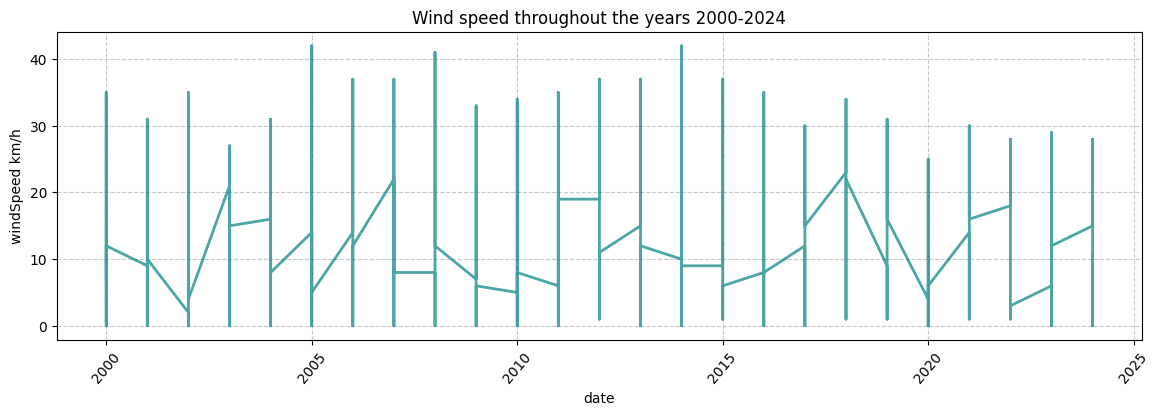

In [446]:
#Plotting the wind speed throughout the years
plt.figure(figsize=(14, 4))
plt.plot(data['year'], data['wdsp'], color="teal", linestyle="-", linewidth="2", alpha=0.7)

plt.xlabel("date")
plt.ylabel("windSpeed km/h")
plt.title("Wind speed throughout the years 2000-2024")


plt.xticks(rotation=50)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [447]:
# Calculate the mean (average) of wind speed for each year in km/h
annual_wind_speed = data.groupby('year')['wdsp'].mean().reset_index()

# Display data
annual_wind_speed.head()

,year,wdsp
0,2000,11.652967
1,2001,10.188079
2,2002,10.393229
3,2003,10.062500
4,2004,10.699653


### Wind Speed trend in 10 years

In the plot below, it is evident that the wind speed at Dublin Airport shows a decreasing trend over the next 10 years, with the average annual speed decreasing from 9.5 to a minimum value of 8.9.

In [448]:
# Prepare the data for regression
X = annual_wind_speed['year'].values.reshape(-1, 1)  # Independent variable (year)
y = annual_wind_speed['wdsp'].values               # Dependent variable (wind speed)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict for the current data
predicted_y = model.predict(X)

# Predict for the next 10 years
future_years = np.arange(X.max() + 1, X.max() + 11).reshape(-1, 1)
future_predictions = model.predict(future_years)

# Combine future predictions into a DataFrame
future_data = pd.DataFrame({
    'year': future_years.flatten(),
    'predicted_wdsp': future_predictions
})



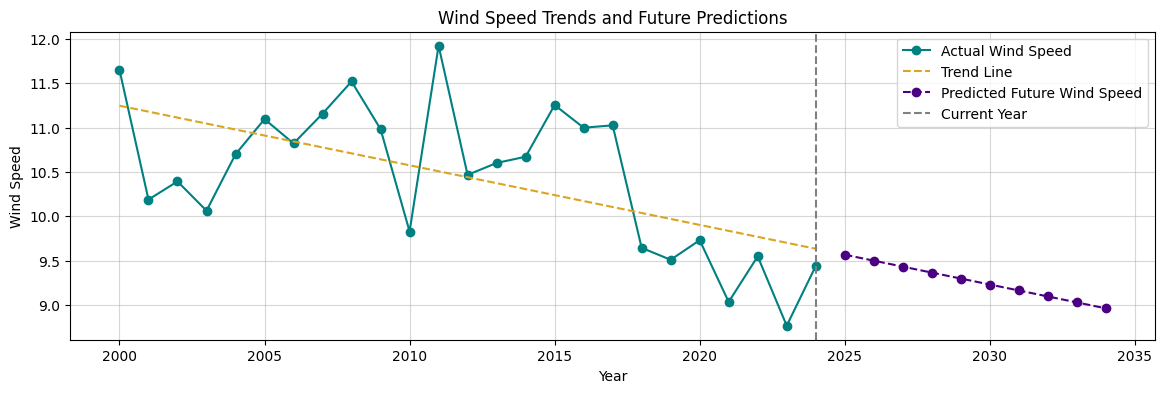

   year  predicted_wdsp
0  2025        9.565822
1  2026        9.498531
2  2027        9.431240
3  2028        9.363949
4  2029        9.296658
5  2030        9.229366
6  2031        9.162075
7  2032        9.094784
8  2033        9.027493
9  2034        8.960202


In [449]:
# Machine Learning (Scikit-Learn)
# Plot actual vs predicted and future predictions
plt.figure(figsize=(14, 4))
plt.plot(annual_wind_speed['year'], annual_wind_speed['wdsp'], label='Actual Wind Speed', color='teal', marker='o')
plt.plot(annual_wind_speed['year'], predicted_y, label='Trend Line', linestyle='--', color='goldenrod')
plt.plot(future_data['year'], future_data['predicted_wdsp'], label='Predicted Future Wind Speed', marker='o', linestyle='--', color='indigo')

plt.axvline(annual_wind_speed['year'].max(), color='gray', linestyle='--', label='Current Year')
plt.xlabel('Year')
plt.ylabel('Wind Speed')
plt.title('Wind Speed Trends and Future Predictions')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Print future predictions
print(future_data)

### Air tempeture

It appears that 2010 was the coldest year, while 2021 was the hottest, with a general upward trend in air temperature continuing through to 2024. This suggests an increase in overall air temperature since 2021.

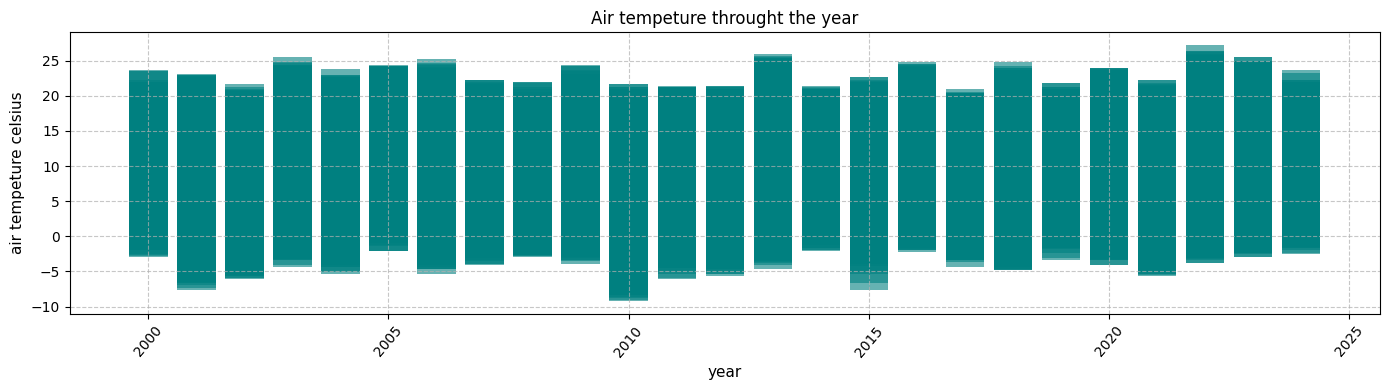

In [450]:

#Plotting the air tempeture through the years

plt.figure(figsize=(14, 4))
plt.bar(data['year'], data['airtemp'], color="teal", alpha=0.6)

plt.xlabel("year",fontsize=11)
plt.ylabel("air tempeture celsius", fontsize=11)
plt.title("Air tempeture throught the year", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation= 50)
plt.tight_layout()
plt.show()

In [451]:
# Calculate the mean (average) of air tempeture for each year in Celsius
annual_air_temp = data.groupby('year')['airtemp'].mean().reset_index()

# Display the aggregated data
annual_air_temp.head()

,year,airtemp
0,2000,9.897771
1,2001,9.553328
2,2002,9.717882
3,2003,9.995515
4,2004,10.294647


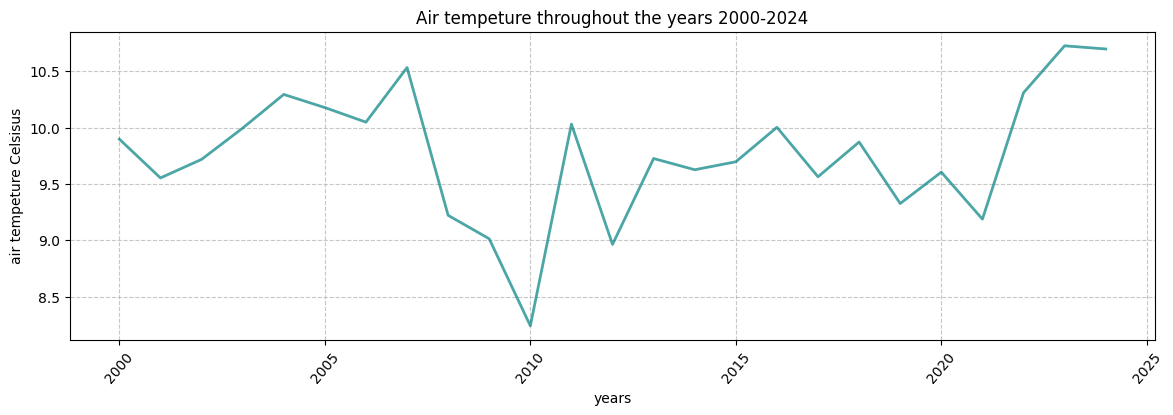

In [452]:
plt.figure(figsize=(14, 4))
plt.plot(annual_air_temp['year'], annual_air_temp['airtemp'], color="teal", linestyle="-", linewidth="2", alpha=0.7)

plt.xlabel("years")
plt.ylabel("air tempeture Celsisus")
plt.title("Air tempeture throughout the years 2000-2024")


plt.xticks(rotation=50)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Air tempeture trend in 10 years

Unlike the trend of wind speed, the air temperature shows a slight increase. The average temperature in the upcoming 10 years is expected to range between 9.87 and 9.95°C.

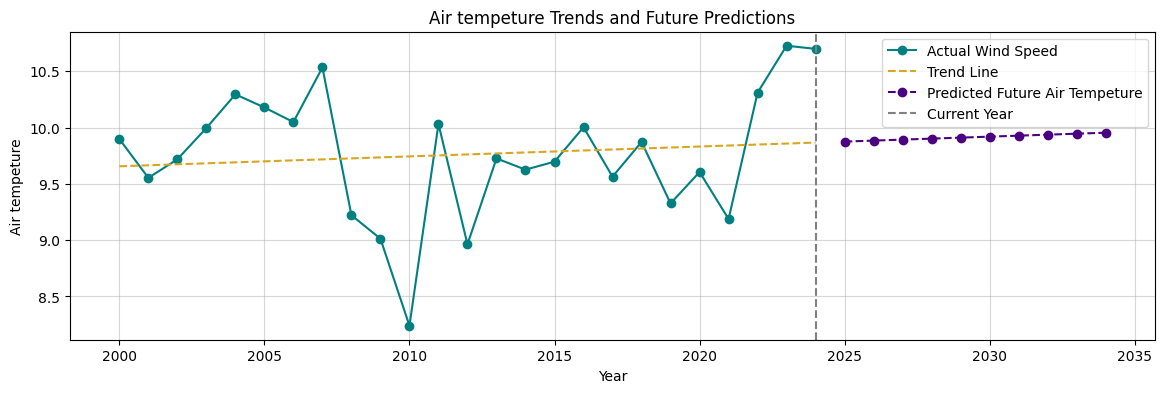

   year  predicted_airtemp
0  2025           9.875129
1  2026           9.883901
2  2027           9.892674
3  2028           9.901447
4  2029           9.910220
5  2030           9.918992
6  2031           9.927765
7  2032           9.936538
8  2033           9.945311
9  2034           9.954083


In [453]:
# Prepare the data for regression
X = annual_air_temp['year'].values.reshape(-1, 1)  # Independent variable (year)
y = annual_air_temp['airtemp'].values               # Dependent variable (wind speed)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict for the current data
predicted_y = model.predict(X)

# Predict for the next 10 years
future_years = np.arange(X.max() + 1, X.max() + 11).reshape(-1, 1)
future_predictions = model.predict(future_years)

# Combine future predictions into a DataFrame
future_data = pd.DataFrame({
    'year': future_years.flatten(),
    'predicted_airtemp': future_predictions
})
# Plot actual vs predicted and future predictions
plt.figure(figsize=(14, 4))
plt.plot(annual_air_temp['year'], annual_air_temp['airtemp'], label='Actual Wind Speed', color='teal', marker='o')
plt.plot(annual_air_temp['year'], predicted_y, label='Trend Line', linestyle='--', color='goldenrod')
plt.plot(future_data['year'], future_data['predicted_airtemp'], label='Predicted Future Air Tempeture', marker='o', linestyle='--', color='indigo')

plt.axvline(annual_wind_speed['year'].max(), color='gray', linestyle='--', label='Current Year')
plt.xlabel('Year')
plt.ylabel('Air tempeture')
plt.title('Air tempeture Trends and Future Predictions')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Print future predictions
print(future_data)

### Wind direction frequency

The following pie charts highlights the wind direction based on the cardinal points. The wind predominantly blows towards the West and South West with a slightly less frequency towards the East and North.

The wind direction data (in degrees) is usually given in terms of cardinal and intercardinal directions to be more precise:

- North (N): 337.5° to 22.5°
- North-East (NE): 22.5° to 67.5°
- East (E): 67.5° to 112.5°
- South-East (SE): 112.5° to 157.5°
- South (S): 157.5° to 202.5°
- South-West (SW): 202.5° to 247.5°
- West (W): 247.5° to 292.5°
- North-West (NW): 292.5° to 337.5°

Below , It is possible to observe pie charts with those classifications.

In [454]:
# Frequency. how often values appears in wddir column.
data['wddir'].value_counts()

wddir
240    3853
260    3805
250    3756
270    3357
230    3270
       ... 
10      303
20      301
360     292
0        71
0         8
Name: count, Length: 74, dtype: int64

In [455]:
# Group by wind cardinal direction and count
data.groupby('wddir').size()


wddir
0       8
10    303
20    301
30    340
40    447
     ... 
50    710
60    606
70    650
80    986
90    784
Length: 74, dtype: int64

     year  month wind_direction_category  count
0    2000      1                    West      1
1    2000      2               Southwest      1
2    2000      3               Southwest      1
3    2000      4                   South      1
4    2000      5                   South      1
..    ...    ...                     ...    ...
295  2024      8               Southwest      1
296  2024      9                   South      1
297  2024     10                   South      1
298  2024     11               Southwest      1
299  2024     12                   South      1

[300 rows x 4 columns]


C:\Users\noemi\AppData\Local\Temp\ipykernel_16676\2082198479.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('terrain')  # Get the 'terrain' colormap


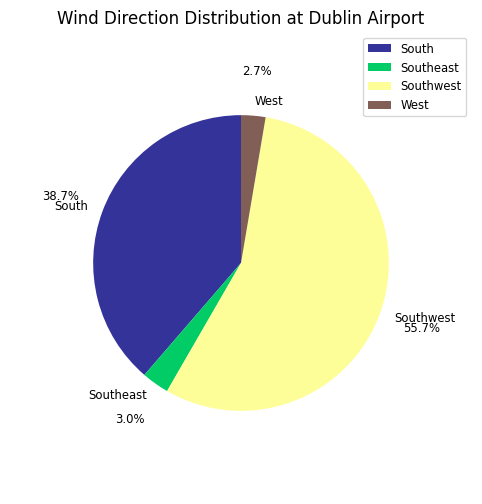

In [456]:
# SQLite
# Open connection to SQLite database
conn = sqlite3.connect('DublinAirport_weather.db')

try:
    # Query to group wind direction categories by month and year
    query = """
        SELECT 
            year,
            month,
            CASE
                WHEN avg_wddir >= 0 AND avg_wddir < 22.5 THEN 'North'
                WHEN avg_wddir >= 22.5 AND avg_wddir < 67.5 THEN 'Northeast'
                WHEN avg_wddir >= 67.5 AND avg_wddir < 112.5 THEN 'East'
                WHEN avg_wddir >= 112.5 AND avg_wddir < 157.5 THEN 'Southeast'
                WHEN avg_wddir >= 157.5 AND avg_wddir < 202.5 THEN 'South'
                WHEN avg_wddir >= 202.5 AND avg_wddir < 247.5 THEN 'Southwest'
                WHEN avg_wddir >= 247.5 AND avg_wddir < 292.5 THEN 'West'
                WHEN avg_wddir >= 292.5 AND avg_wddir < 337.5 THEN 'Northwest'
                WHEN avg_wddir >= 337.5 AND avg_wddir <= 360 THEN 'North'
            END AS wind_direction_category,
            COUNT(*) AS count
        FROM (
            SELECT 
                CAST(strftime('%Y', date) AS INTEGER) AS year,       -- Extract year
                CAST(strftime('%m', date) AS INTEGER) AS month,      -- Extract month
                AVG(wddir) AS avg_wddir                             -- Calculate average wind direction
            FROM DublinAirport_weather_data
            GROUP BY year, month
        )
        GROUP BY year, month, wind_direction_category
        ORDER BY year, month;
    """

    # Execute the query and load the results into a pandas DataFrame
    result = pd.read_sql(query, conn)

    # Display the result (optional)
    print(result)

    # Aggregate counts by wind direction category
    category_counts = result.groupby('wind_direction_category')['count'].sum()

    # Prepare data for the pie chart
    labels = category_counts.index
    sizes = category_counts.values

    # Generate colors from the 'terrain' colormap
    cmap = cm.get_cmap('terrain')  # Get the 'terrain' colormap
    colors = [cmap(i / len(labels)) for i in range(len(labels))]  # Generate colors for the categories

    # Create the pie chart
    fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size
    ax.pie(sizes,  # Use the values for the pie sizes
           labels=labels,  # Use the labels
           autopct='%1.1f%%',  # Display percentages
           startangle=90,  # Start angle for better layout
           textprops={'size': 'small'},  # Size of the text in the pie chart
           labeldistance=1.1,  # Distance of labels from the center
           pctdistance=1.3,  # Distance of percentage labels from the center
           radius=0.8,  # Size of the pie chart
           colors=colors)  # Use the 'terrain' colormap-generated colors

    # Add title and legend
    plt.title('Wind Direction Distribution at Dublin Airport')

    # Add a legend with labels
    plt.legend(labels=labels, loc="best", fontsize="small")

    # Display the pie chart
    plt.show()

except sqlite3.Error as e:
    print(f"SQLite error: {e}")

# Close the connection
conn.close()


In [457]:
# Convert to numeric, convert invalid entries to NaN
data['wddir'] = pd.to_numeric(data['wddir'], errors='coerce')
# Check for NaN values
print(data['wddir'].isna().sum())  # Check for NaN values

0


In [458]:
# Define the cardinal directions based on degrees
def get_cardinal_direction(degrees):
    if degrees == 0 or degrees == 360:
        return 'North'
    elif degrees == 90:
        return 'East'
    elif degrees == 180:
        return 'South'
    elif degrees == 270:
        return 'West'
    else:
        return 'Other'

# Apply the function to the 'wddir' column
data['wddir_cardinal'] = data['wddir'].apply(get_cardinal_direction)

# Show the counts of cardinal directions
print(data['wddir_cardinal'].value_counts())


wddir_cardinal
Other    77107
West      5757
East      1576
South      838
North      834
Name: count, dtype: int64


In [459]:
# Identify and check data values from'other'row 
other_rows = data[data['wddir_cardinal'] == 'Other']
# Check the wind distribution for all those values
print(other_rows['wddir'].value_counts())


wddir
250    6202
240    6184
260    5870
230    5285
220    4309
280    4236
140    3549
290    3128
210    3101
150    2770
200    2679
130    2517
300    2407
310    2040
120    1822
80     1781
110    1726
160    1604
100    1575
320    1536
190    1498
70     1236
330    1232
40     1173
50     1116
60     1114
340    1071
170    1046
20      872
350     827
30      824
10      777
Name: count, dtype: int64


C:\Users\noemi\AppData\Local\Temp\ipykernel_16676\1514315048.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('terrain')
C:\Users\noemi\AppData\Local\Temp\ipykernel_16676\1514315048.py:15: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "_". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.pie(sizes, labels=labels, colors=colors, hatch=hatch_patterns, shadow=False,  textprops={'size': 'smaller'}, radius=0.8)


<function matplotlib.pyplot.show(close=None, block=None)>

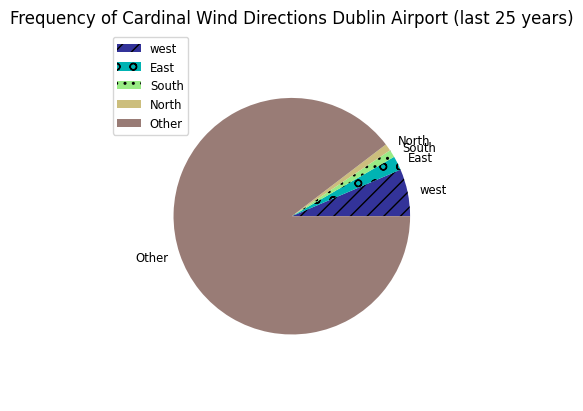

In [460]:
# Plotting a pie chart about the frequency of cardinal wind directions
# Data for pie chart
labels = 'west', 'East', 'South', 'North', 'Other'
sizes = [14070, 4210, 2263, 2112, 195769]

# Generate Colors from colormap module from matplotlib
cmap = cm.get_cmap('terrain')
colors = [cmap(i / len(labels)) for i in range(len(labels))]

# Optional hatch patterns
hatch_patterns= ['//', 'o','..','_','']

# Create plot
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, hatch=hatch_patterns, shadow=False,  textprops={'size': 'smaller'}, radius=0.8)
plt.title('Frequency of Cardinal Wind Directions Dublin Airport (last 25 years)')
plt.legend(labels, loc="best", fontsize="small")
plt.show

In [461]:
# Function to map degrees to cardinal or intercardinal directions
def get_cardinal_direction(degrees):
    if 337.5 <= degrees < 360 or 0 <= degrees < 22.5:
        return 'North (N)'
    elif 22.5 <= degrees < 67.5:
        return 'North-East (NE)'
    elif 67.5 <= degrees < 112.5:
        return 'East (E)'
    elif 112.5 <= degrees < 157.5:
        return 'South-East (SE)'
    elif 157.5 <= degrees < 202.5:
        return 'South (S)'
    elif 202.5 <= degrees < 247.5:
        return 'South-West (SW)'
    elif 247.5 <= degrees < 292.5:
        return 'West (W)'
    elif 292.5 <= degrees < 337.5:
        return 'North-West (NW)'
    else:
        return 'Invalid'

# Apply the function to the 'wddir' column in the  dataset to convert numerica values into corresponding cateogries.
data['wddir_cardinal'] = data['wddir'].apply(get_cardinal_direction)

# Display the updated dataframe with cardinal directions
print(data[['wddir', 'wddir_cardinal']].head())


   wddir   wddir_cardinal
0    250         West (W)
1    250         West (W)
2    240  South-West (SW)
3    230  South-West (SW)
4    250         West (W)


C:\Users\noemi\AppData\Local\Temp\ipykernel_16676\128538044.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('terrain')
C:\Users\noemi\AppData\Local\Temp\ipykernel_16676\128538044.py:16: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "_". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.pie(sizes, labels=labels, colors=colors, hatch=hatch_patterns, shadow=False,  textprops={'size': 'smaller'}, radius=0.8)


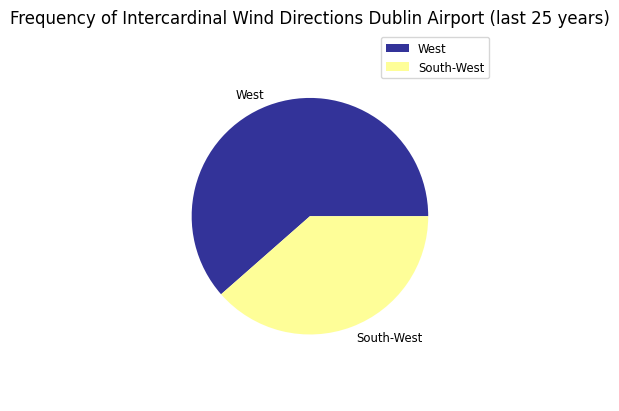

In [462]:
# Plot pie chart of Cardinal and intercardinal wind directions

# Data for the pie chart
labels = ['West', 'South-West']
sizes = [750, 470]

# Generate colors from the 'terrain' colormap
cmap = cm.get_cmap('terrain')
colors = [cmap(i / len(labels)) for i in range(len(labels))]

# Optional hatch patterns
hatch_patterns = ['_', '_']

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, hatch=hatch_patterns, shadow=False,  textprops={'size': 'smaller'}, radius=0.8)

# Add title and legend
plt.title('Frequency of Intercardinal Wind Directions Dublin Airport (last 25 years)')
plt.legend(labels, loc="best", fontsize="small")

# Show the plot
plt.show()


### Compare wind speed with air tempeture

The following plot illustrates that wind speed tends to be higher at moderate temperatures, around 10°C. On the other hand, wind speed appears weaker when the air temperature is either below -5°C or exceeds 25°C.

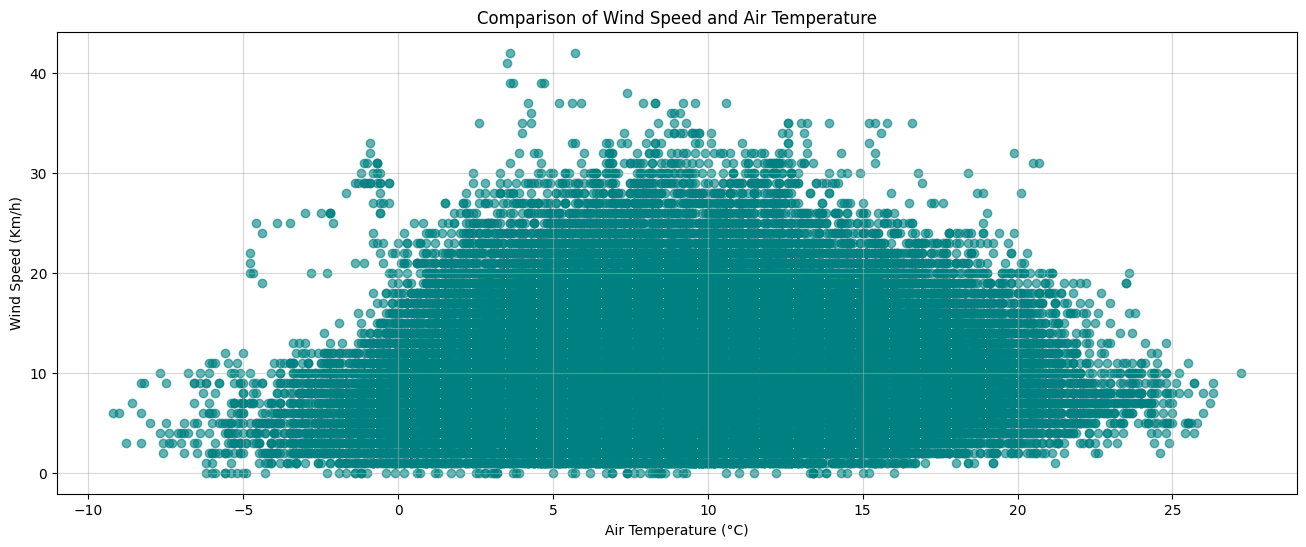

In [464]:
# Scatter plot to compare wind speed and air temperature
plt.figure(figsize=(16, 6))
plt.scatter(data['airtemp'], data['wdsp'], alpha=0.6, color='teal')

# Add labels
plt.xlabel('Air Temperature (°C)')
plt.ylabel('Wind Speed (Km/h)')

# Add tittle 
plt.title('Comparison of Wind Speed and Air Temperature')


# Display grid
plt.grid(alpha=0.5)

# Enable interactive mode for zoom and pan
plt.ion()

# Show plot
plt.show()



## Conclusion
***

Wind speed reached its highest levels in the years 2005, 2008, and 2014. In contrast, the years with the lowest wind speeds were 2003 and 2024. The wind speed trend indicates a decrease over the next 10 years, with the average annual wind speed dropping from 9.5 km/h to a low of 8.9 km/h.

Regarding air temperature, 2010 recorded the lowest average temperature, falling below 8.5°C, while 2007 and 2023 experienced the highest average temperatures, exceeding 10.5°C. Since 2021, air temperature has been on an upward trajectory. The trend for the next 10 years (until 2035) suggests a slight increase in air temperature, with an average around 9.9°C.

In terms of wind direction, the predominant directions are southwest and south, with less frequent occurrences of wind coming from the west and southeast.


#### Reflection on Applying This Data to Airports and Wind Farms:

Reflection on Applying This Data to Airports and Wind Farms:

This analysis of wind speed and air temperature trends is crucial for optimizing airport operations. Understanding wind patterns can help airports plan for potential disruptions and particularly in the management of flight runway usage for take off and landing. 
For wind farms, this data is equally valuable as it helps determine the most efficient locations for turbine installations. The ability to predict wind behavior and its relationship with temperature can guide decisions on where to place wind farms for optimal energy production, ensuring both environmental sustainability and cost-effectiveness. In this case of study, Dublin Airport, with a predicted decline in wind speed over the next 10 years, might not be the most suitable location to install a wind farm development. However, It is important to consider other factors and long term patterns.


## References

- Jupyter notebook format:
https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet

- Jupyter notebook text formatting:
https://www.earthdatascience.org/courses/intro-to-earth-data-science/file-formats/use-text-files/format-text-with-markdown-jupyter-notebook/

- Free images:
https://pixabay.com/

- Classify the wind direction:
https://stackoverflow.com/questions/35864909/classify-the-wind-direction-in-several-classes

- pandas.to_datetime:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html

- Linear Regression using sklearn:
https://www.geeksforgeeks.org/python-linear-regression-using-sklearn/

- Linear models: 
https://scikit-learn.org/stable/modules/linear_model.html

- Specifying colors plots:
https://matplotlib.org/stable/users/explain/colors/colors.html#colors-def

- SQLite Commands:
https://www.sqlite.org/cli.html

- Group by month and year SQLite:
https://www.geeksforgeeks.org/how-to-group-by-month-and-year-in-sqlite/

- Train test split(machine learning):
https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html



***
### End